# Sea ice drift

This notebook plots [NSIDC sea ice motion vectors](https://nsidc.org/data/nsidc-0116). The main cause of sea ice motion is wind applying force on the surface of the ice. Visualizing the direction and magnitude of sea ice drift gives an understanding of where and how fast sea ice is moving. Here, we overlay sea ice drift vectors on other variables in the xarray dataset.  
 
**Input**:
 - xarray dataset from the jupyter book's google bucket
 
 
 **Output**: 
  - Plots of sea ice drift

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !apt-get install -qq libgdal-dev libproj-dev
    !pip install --no-binary shapely shapely --force
    !pip install -q pyproj
    !pip install cartopy
    !pip install netcdf4
    !pip install xarray==0.16.0

## Import notebook dependencies

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
from textwrap import wrap
import pandas as pd

#axes needed for plotting
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# Ignore warnings in the notebook to improve display
# You might want to remove this when debugging/writing new code
import warnings
warnings.filterwarnings('ignore')
 
#increase resolution for notebook outputs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

## Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

In [3]:
!gsutil -m cp gs://icesat2-book-data/icesat2-book-winter-data.nc ./
dataset = xr.open_dataset('icesat2-book-winter-data.nc')

Copying gs://icesat2-book-data/icesat2-book-winter-data.nc...
\ [1/1 files][163.4 MiB/163.4 MiB] 100% Done                                    
Operation completed over 1 objects/163.4 MiB.                                    


## Plot one month of drift data 

### Define function

In [4]:
def plotDriftsOneMonth(dataset, dataVar, month, minval = 0, maxval = None, cbarTicks = None, cmap = 'YlGnBu', res = 4, scale_vec = 100, vector_val = 10): 
    """Plots map of the arctic on North Pole Stereo projection with one month of data and drift vectors overlayed.
   
    Args:
        dataset (xr Dataset): dataset from google bucket
        dataVar (str): data variable of interest, to overlay vectors on
        month (str): month and year of interest, i.e. 'Dec 2019' (does not need to be in any particular format)
        minval (int): minimum drift value (default to 0 cm)
        minval (int): maximum drift value (default to 15 cm)
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [0,5,10,15])
        cmap (str, optional): color map (default to GnBu)
        res (int): resolution to display vectors (default to 4)
        scale_vec (int): scaling value for displaying vectors (default to 100)
        vector_val (int): value of vector to display in quiver key (default to 10 cm)
        
    Returns:
        Figure displayed in notebook 
    
    Note: 
        Follows method from https://github.com/SciTools/cartopy/issues/1179
    """
    #define projection and transform
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    
    #initialize the figure and axes 
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection = proj)
    
    #plot vector magnitudes 
    uvelT = dataset.sel(time = month)['drifts_uT'].values[0]
    vvelT = dataset.sel(time = month)['drifts_vT'].values[0]
    
    #define cbar ticks 
    cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
    
    #plot data 
    im = dataset[dataVar].where(dataset['seaice_conc_monthly_cdr'] > 0.5).sel(time = month).plot(x = 'longitude', y = 'latitude', vmin = minval, 
                                vmax = maxval, extend = 'both', ax = ax, add_colorbar = True, transform = transform, zorder = 2, cmap = cmap,
                                cbar_kwargs = {'label':"\n".join(wrap(dataset[dataVar].attrs['long_name'] + ' (' + dataset[dataVar].attrs['units'] + ')', 40)), 'orientation': 'horizontal', 'shrink': 0.75, 'pad': 0.025})
    
    #add title
    ax.set_title("\n".join(wrap(month + ": Drift vectors overlayed on " + dataset[dataVar].attrs['long_name'], 36)), fontsize = 'x-large')
    
    #plot vectors 
    u_src_crs = uvelT / np.cos(dataset.latitude.values / 180 * np.pi)
    v_src_crs = vvelT
    magn_src_crs = np.sqrt(u_src_crs**2 + v_src_crs**2)
    var_u_scaled = u_src_crs * dataset['drifts_magnitude'].sel(time = month).values[0] / magn_src_crs
    var_v_scaled = v_src_crs * dataset['drifts_magnitude'].sel(time = month).values[0] / magn_src_crs
    
    #add quiver key
    Q = ax.quiver(dataset.longitude.values[::res, ::res], dataset.latitude.values[::res, ::res], var_u_scaled[::res, ::res], 
        var_v_scaled[::res, ::res], transform = transform, units = 'inches', scale = scale_vec, zorder = 5)
    qk = plt.quiverkey(Q, 0.85, 0.85, vector_val, str(vector_val) + ' ' + dataset['drifts_uT'].attrs['units'], coordinates = 'axes', zorder = 11, fontproperties = {'size': 12})   
    
    #add features to the map
    ax.coastlines(linewidth = 0.15, color = 'black', zorder = 10) #add coastlines 
    ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
    #ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
    ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.7, linestyle = '--', zorder = 6) #add gridlines
    ax.set_extent([-179, 179, 55, 90], crs = transform) #zoom in so map only displays the Arctic
    
    #display figure in notebook 
    plt.show()

### Plot map for drift vector magnitude

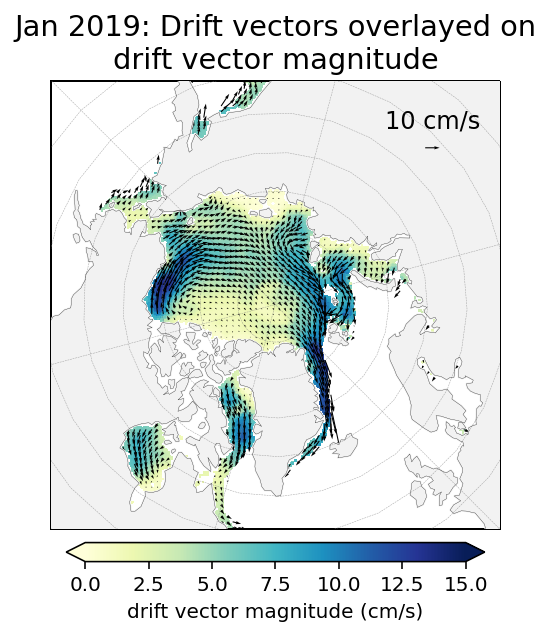

In [5]:
plotDriftsOneMonth(dataset, dataVar = 'drifts_magnitude', month = 'Jan 2019', maxval = 15, cbarTicks = np.arange(0, 15 + 5,5))

### Plot map for ICESat-2 sea ice thickness

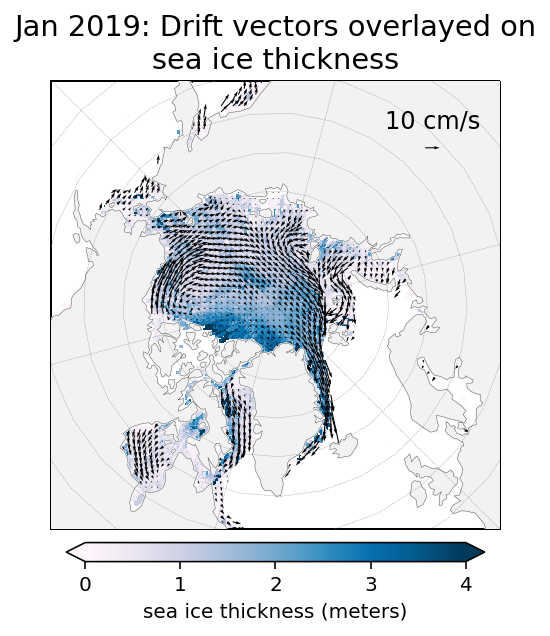

In [6]:
plotDriftsOneMonth(dataset, dataVar = 'ice_thickness_filled', month = 'Jan 2019', cmap = 'PuBu', maxval = 4)

## Plot winter data
 - This function is modified from the plotDriftsOneMonth function above to plot 6 months of data instead of one
 - Winter is defined as the months Nov, Dec, Jan, Feb, Mar, Apr

### Define function

In [7]:
def plotWinterDrifts(dataset, dataVar, minval, maxval, cbarTicks = None, title = "", cmap = 'YlGnBu', res = 6, scale_vec = 100, vector_val = 10):
    """Plot maps of the arctic on North Pole Stereo projection with several months of data overlayed, along with the sea ice edge for each month and sea ice drift. 
   
    Args:
        dataset (xr Dataset): dataset from google bucket
        dataVar (str): variable of interest
        minval, maxval (int): minimum and maximum values for the data variable 
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [minval + 1, maxval +1])
        title (str, optional): title of subplots (default to empty string)
        cmap (str, optional): color map (default to viridis)
        res (int): resolution to display vectors (default to 6)
        scale_vec (int): scaling value for displaying vectors (default to 100)
        vector_val (int): value of vector to display in quiver key (default to 10 cm)
        
    Returns:
        Figure displayed in notebook 

    """
    #define projection and transform
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    
    #initialize figure and axes
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7.8, 5.8), subplot_kw={'projection': proj})
    
    for i in range(len(dataset.time)):
        ax = axs.flatten()[i]
        
        #plot data 
        im = dataset[dataVar].where(dataset['seaice_conc_monthly_cdr'] > 0.5).isel(time = i).plot(x = 'longitude', y = 'latitude', vmin = minval, vmax = maxval, extend = 'both', 
                    ax = ax, add_colorbar = False, transform = transform, zorder = 2, cmap = cmap)
    
        #add features to map
        ax.coastlines(linewidth=0.25, color = 'black', zorder = 10) #add coastlines 
        ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
        ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
        ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.75, linestyle='--', zorder = 6) #add gridlines
        ax.set_extent([-179, 179, 50, 90], crs = transform) #zoom in so map only displays the Arctic
        ax.set_title(pd.to_datetime(dataset.time.values).strftime('%B %Y')[i])
        
        #plot vectors
        uvelT = dataset['drifts_uT'].isel(time = i).values
        vvelT = dataset['drifts_vT'].isel(time = i).values
        u_src_crs = uvelT / np.cos(dataset.latitude.values / 180 * np.pi)
        v_src_crs = vvelT
        magn_src_crs = np.sqrt(u_src_crs**2 + v_src_crs**2)
        var_u_scaled = u_src_crs * dataset['drifts_magnitude'].isel(time = i).values / magn_src_crs
        var_v_scaled = v_src_crs * dataset['drifts_magnitude'].isel(time = i).values / magn_src_crs

        #add quiver key
        Q = ax.quiver(dataset.longitude.values[::res, ::res], dataset.latitude.values[::res, ::res], var_u_scaled[::res, ::res], 
            var_v_scaled[::res, ::res], transform = transform, units = 'inches', scale = scale_vec, zorder = 7)
        qk = plt.quiverkey(Q, 0.85, 0.85, vector_val, str(vector_val) + ' ' + dataset['drifts_uT'].attrs['units'], coordinates = 'axes', zorder = 11, fontproperties = {'size': 10})   

        #add colorbar
        cax = fig.add_axes([0.34, 0.08, 0.35, 0.03])
        cb = fig.colorbar(im,cax = cax,extend='both',orientation = 'horizontal')
        cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
        cb.set_ticks(cbarTicks)
        cb.set_label("\n".join(wrap(dataset[dataVar].attrs['long_name'] + ' (' + dataset[dataVar].attrs['units'] + ')', 38)), fontsize = 11)
        
    #add a title
    plt.suptitle("\n".join(wrap(title + ': ' + 'Drift vectors overlayed on ' + dataset[dataVar].attrs['long_name'], 55)), fontsize = 18, y = 1.03, fontweight = 'medium')
    
    #display figure in notebook
    plt.subplots_adjust(wspace=0.05, hspace=0.13)
    plt.tight_layout()
    plt.show()

### Plot maps for different data variables
Here, we will call the winter plotting function on some of the variables in the dataset using different arguments for minimum & maximum values and colormap to allow for visualization of the data. 

#### Sea ice drift magnitude

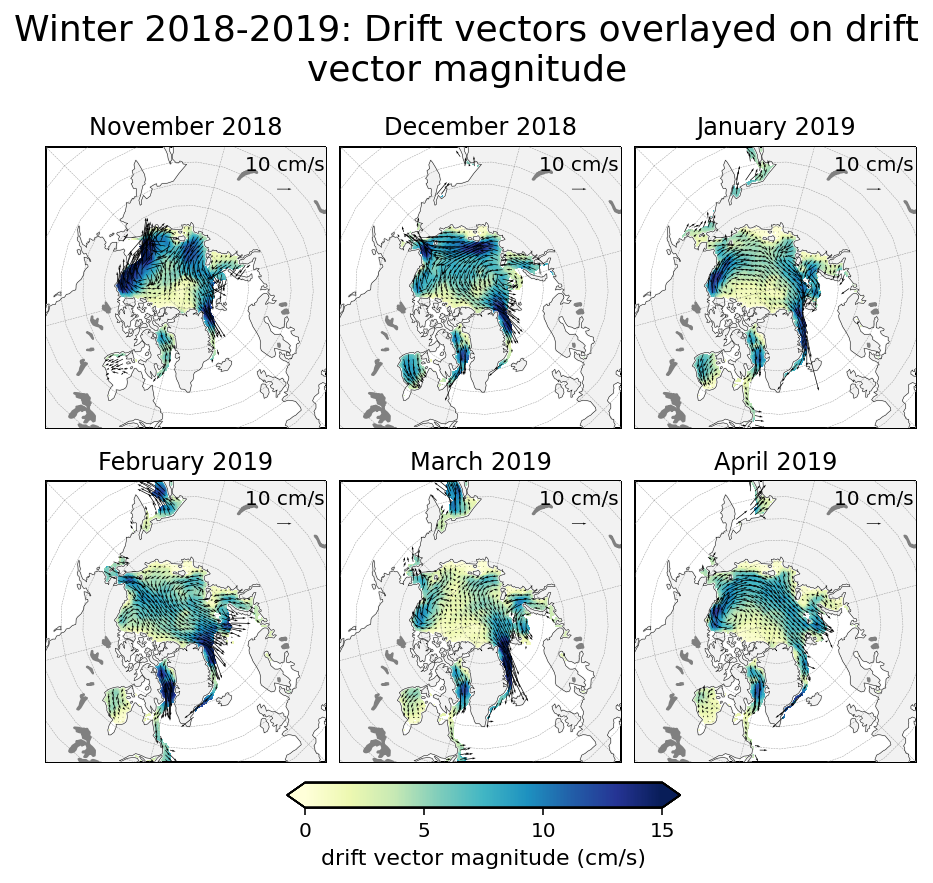

In [8]:
#winter 2019-2020
plotWinterDrifts(dataset.sel(time = slice('Nov 2018', 'Apr 2019')), dataVar = 'drifts_magnitude', cbarTicks = np.arange(0,15 + 5, 5),
               minval = 0, maxval = 15, title = 'Winter 2018-2019')

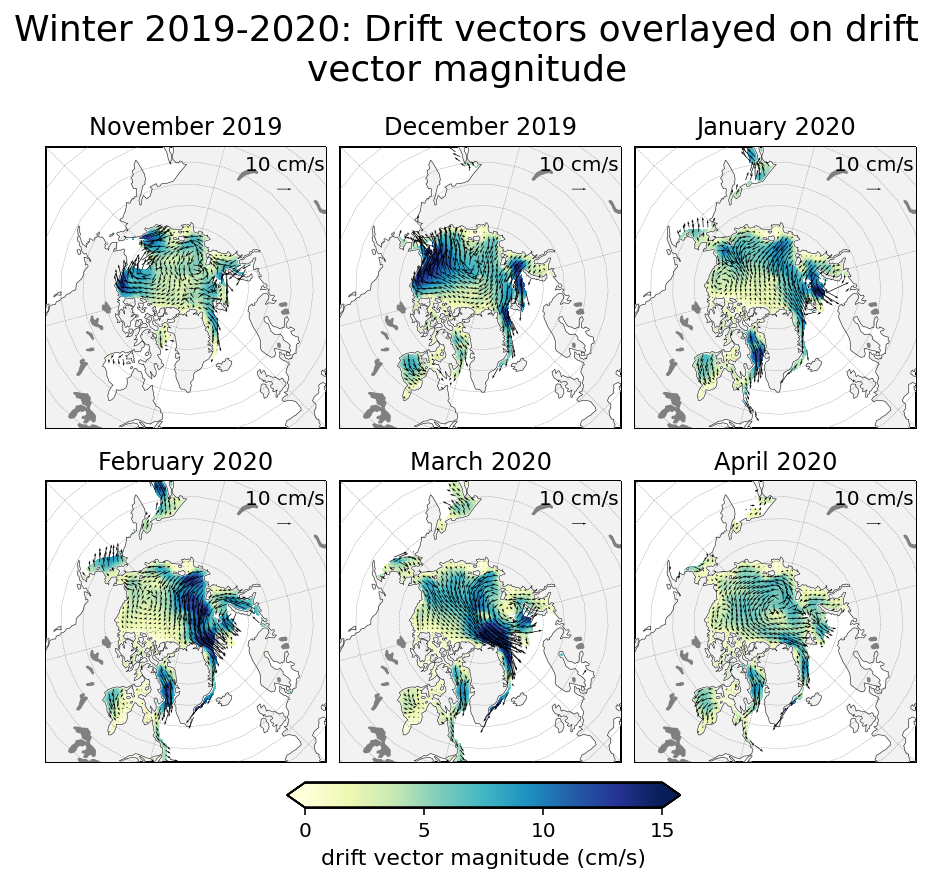

In [9]:
#winter 2019-2020
plotWinterDrifts(dataset.sel(time = slice('Nov 2019', 'Apr 2020')), dataVar = 'drifts_magnitude', cbarTicks = np.arange(0,15 + 5, 5),
               minval = 0, maxval = 15, title = 'Winter 2019-2020')

### ICESat-2 sea ice thickness

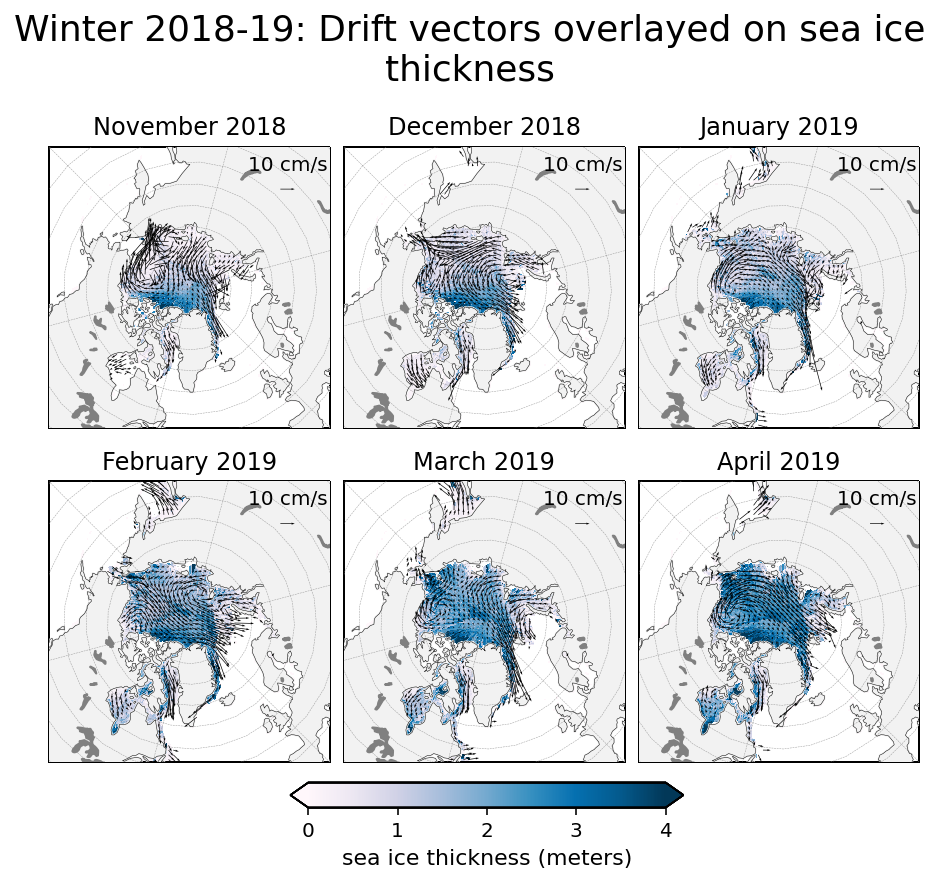

In [10]:
#winter 2018-2019
plotWinterDrifts(dataset.sel(time = slice('Nov 2018', 'Apr 2019')), dataVar = 'ice_thickness_filled',
               minval = 0, maxval = 4, cmap = 'PuBu', title = 'Winter 2018-19')

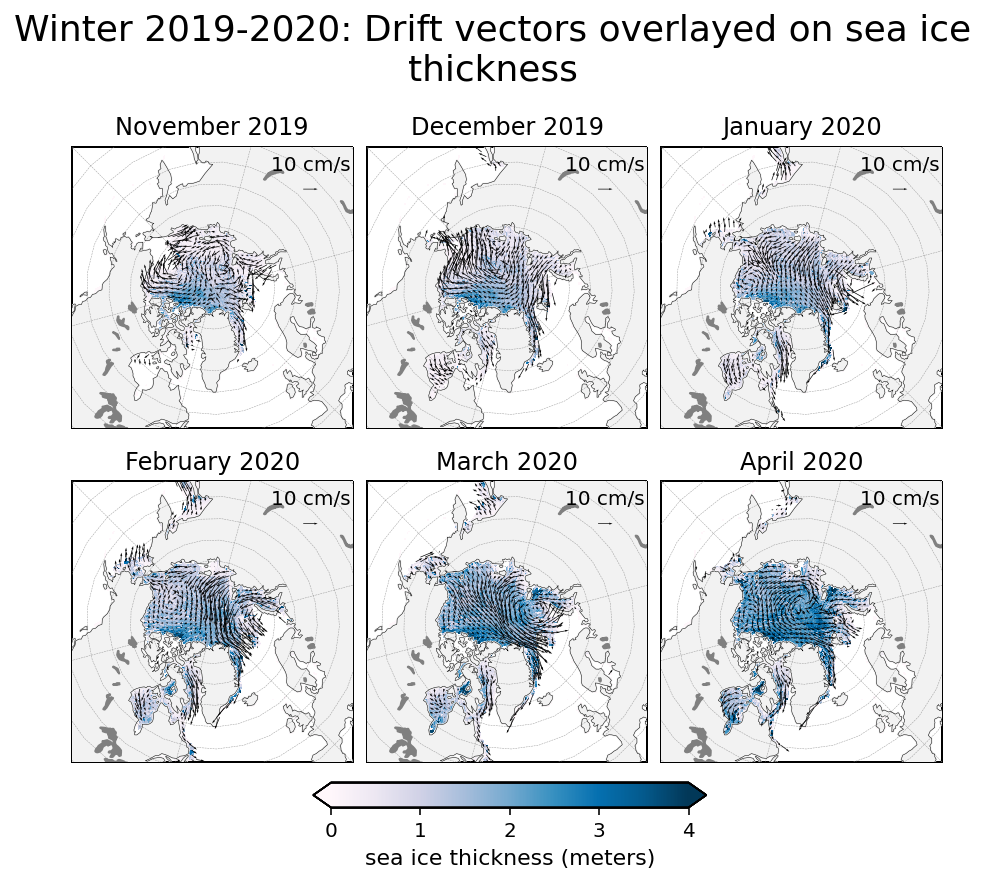

In [11]:
#winter 2019-2020
plotWinterDrifts(dataset.sel(time = slice('Nov 2019', 'Apr 2020')), dataVar = 'ice_thickness_filled',
               minval = 0, maxval = 4, cmap = 'PuBu', title = 'Winter 2019-2020')